In this example we will use ABMax to create a simple financial market simulation. Where, noisy traders place buy and sell orders across different limit order books.

The simulation consists of :
1) Limit order book agents: representing the different assets in the market.
2) Noisy trader agents: representing the traders in the market.

In [12]:
import sys
sys.path.append('../../ABMax/')


import jax.numpy as jnp
import jax.random as random
import jax
import flax

from flax import struct

from structs import *
from functions import *
from contexts.finance.algorithms import *

Preliminaries:
1. structs.py: Contains the data structures from ABMax needed for the simulation.
2. functions.py: Contains the functions needed to run the simulation.
3. JAX version: 0.4.13
4. flax version: 0.7.4

In [13]:
print("JAX version:", jax.__version__)
print("Flax version:", flax.__version__)

JAX version: 0.4.13
Flax version: 0.7.4


Global parameters needed for the simulation

In [ ]:
DT = 1.0 # Time step for simulation
KEY = jax.random.PRNGKey(1) # Random key for JAX
NUM_STEPS = 100 # Number of steps to simulate

# Order params
ORDER_AGENT_TYPE = 0 # to differentiate between order agent and trader agent
MAX_NUM_ORDERS = 1000 # max number of orders in any LOB
BUY_ORDER_POLARITY = jnp.array([0], dtype=jnp.int32) # polarity for buy orders
SELL_ORDER_POLARITY = jnp.array([1], dtype=jnp.int32) # polarity for sell orders
STARTING_PRICE = 100.0 # starting price for everything
MIN_ORDER_PRICE = 0.0 # min price for orders
MAX_ORDER_PRICE = 1000.0 # max price for orders
NUM_LOBS = 5

#trader params
MAX_NUM_TRADERS = 10 # number of traders in the market
TRADER_AGENT_TYPE = 1 # to differentiate between order agent and trader agent

Market_create_params = Params(content={"num_traders": MAX_NUM_TRADERS, "trader_agent_type": TRADER_AGENT_TYPE, "starting_price": STARTING_PRICE, "max_num_orders": MAX_NUM_ORDERS,
                                       "order_agent_type": ORDER_AGENT_TYPE, "buy_order_polarity": BUY_ORDER_POLARITY, "sell_order_polarity": SELL_ORDER_POLARITY, "min_order_price": MIN_ORDER_PRICE, 
                                       "max_order_price": MAX_ORDER_PRICE})

Step 1: Define the Order agent by inheriting from structs.Agent.
An order agent agent is defined by:
1. State:
    - num_shares: number of shares remaining to be traded
    - remove_flag: flag to indicate if the order is removed
2. Parameters:
    - polarity: buy or sell.
    - price: price of the order.
    - trader_id: id of the trader who placed the order.

The order agent is responsible for:
1. Reducing the number of shares when a trade occurs.
2. Setting the remove flag when the order is fully executed.

Thus, the Order(Agent) class implements:
1. create_agent(): to create an empty order agent.
2. step_agent(): to update the state of the order agent.
3. add_agent_sci(): to update the order agent with details of a new order placed by a trader. This is trader specific and thus uses sort-count-iterate kernel for execution.
4. remove_agent(): to remove the order agent when it is fully executed. This is not trader specific and thus uses set-mask kernel for execution.

In [15]:
@struct.dataclass
class Order(Agent):
    
    @staticmethod
    def create_agent(type: jnp.int32, params: Params, id: jnp.int32, active_state: bool, key: jax.random.PRNGKey) -> Agent:
        '''
        Create a blank order agent, assumption: active_state is false

        args:
            type: the type of the agent
            params: parameters to create the agent, should contain polarity
            id: the id of the agent
            active_state: whether the agent is active or not
            key: random key for agent creation, not used here
        returns:
            a blank order agent with the given type, params, id, and active_state
        '''
        num_shares = jnp.array([0])  # number of shares remaining in the order # dont put -1 as cumsum will not work
        remove_flag = jnp.array([0]) # flag to indicate if the order is removed
        agent_state_content = {"num_shares": num_shares, "remove_flag": remove_flag}
        agent_state = State(content=agent_state_content) 

        
        polarity = params.content["polarity"] #params.content["polarity"] # jnp.array([0]) -> buy, jnp.array([1]) ->sell
        min_order_price = params.content["min_order_price"]
        max_order_price = params.content["max_order_price"]
        price = jax.lax.cond(polarity[0] == 0, lambda _: jnp.array([min_order_price]), lambda _: jnp.array([max_order_price]), None) # blank_price, 0 for buy, 1000 for sell, makes it easy to sort orders
        trader_id = jnp.array([-1]) # id of the trader who placed the order, -1 for inactive orders

        agent_params = Params(content = {"polarity": polarity, "price": price, "trader_id": trader_id})

        agent = Order(agent_type=type, params=agent_params, id=id, active_state=active_state, state=agent_state, policy=None, key=key, age = 0.0)
        return agent
    
    @staticmethod
    def step_agent(agent: Agent, input: Signal, step_params: Params) -> Agent:
        '''
        deplete the number of shares remaining in the order by the input amount
        If the number of shares remaining is 0, set the remove_flag to 1, indicating the order is ready to be removed.
        Does nothing if the order is inactive

        args:
            agent: the order agent to be stepped
            input: the input signal containing the number of shares to remove
            step_params: parameters for the step, should contain dt (time step)
        returns:
            the updated order agent 

        '''
        def step_active_agent():
            num_shares_remove = input.content["num_shares_remove"]
            num_shares = agent.state.content["num_shares"]
            
            num_shares = jnp.maximum(num_shares - num_shares_remove, 0)
            remove_flag = jax.lax.cond(num_shares[0] == 0, lambda _: jnp.array([1]), lambda _: jnp.array([0]), None)
            agent_state_content = {"num_shares": num_shares, "remove_flag": remove_flag}
            agent_state = State(content=agent_state_content)

            dt = step_params.content["dt"]
            return agent.replace(state=agent_state, age=agent.age + dt)
        
        def step_inactive_agent():
            # Inactive agents do not change state, just return the agent as is
            return agent
        
        return jax.lax.cond(agent.active_state, lambda _: step_active_agent(), lambda _: step_inactive_agent(), None)
    

    @staticmethod
    def add_agent_sci(agents, idx, add_params) -> Agent:
        set_indx = add_params.content["set_indx"]
        
        order_to_add = jax.tree_util.tree_map(lambda x: x[set_indx[idx]], agents)
        
        trader_id = add_params.content["trader_id_list"][idx] # which trader has placed the order
        price = add_params.content["price_list"][idx] # whats the price of the order
        num_shares = add_params.content["num_shares_list"][idx] # how many shares in the order
        
        polarity = order_to_add.params.content["polarity"]
        
        remove_flag = jnp.array([0])
        agent_state = State(content={"num_shares": num_shares, "remove_flag": remove_flag})

        agent_params = Params(content = {"polarity": polarity, "price": price, "trader_id": trader_id})

        return order_to_add.replace(state=agent_state, params=agent_params, active_state=1, age=0.0)
    

    @staticmethod
    def remove_agent(agent:Agent, remove_params:Params)->Agent:
        '''
        remove an agent by replacing it with a blank order agent based on its polarity
        arguments:
            agent: the agent to be removed
            remove_params: information about the agent to be removed, not used here
        returns:
            a blank order agent with the same polarity as the removed agent
        '''
        num_shares = jnp.array([0]) # don't put -1 as cumsum will not work
        remove_flag = jnp.array([0]) 
        agent_state_content = {"num_shares": num_shares, "remove_flag": remove_flag}
        agent_state = State(content=agent_state_content)

        polarity = agent.params.content["polarity"]
        min_order_price = remove_params.content["min_order_price"]
        max_order_price = remove_params.content["max_order_price"]
        price = jax.lax.cond(polarity[0] == 0, lambda _: jnp.array([min_order_price]), lambda _: jnp.array([max_order_price]), None)
        trader_id = jnp.array([-1]) # id of the trader who placed the order, -1 for inactive orders
        agent_params = Params(content = {"polarity": polarity, "price": price, "trader_id": trader_id})

        return agent.replace(state=agent_state, params=agent_params, active_state=0, age=0.0)



Step 2: Define the Trader agent by inheriting from structs.Agent.
A trader agent is defined by:
1. State:
    - cash: Cash available to the trader.
    - shares: An array of number of shares held by the trader across different limit order books.
    - beliefs: An array of belief prices across different limit order books. sampled from a uniform distribution around the limit order book prices.
    - buy_flag: An array of flags indicating if the trader is willing to buy across different limit order books.
    - buy_num_shares: An array of number of shares the trader is willing to buy across different limit order books.
    - buy_price: An array of prices at which the trader is willing to buy across different limit order books.
    - sell_flag: An array of flags indicating if the trader is willing to sell across different limit order books.
    - sell_num_shares: An array of number of shares the trader is willing to sell across different limit order books.
    - sell_price: An array of prices at which the trader is willing to sell across different limit order books.
2. Parameters:
    - starting_price: Initial price of the limit order book.
    - belief_span: The belief span around the limit order book price.

The trader agent is responsible for updating:
- buy_flag, sell_flag: randomly decide to buy or sell across different limit order books.
- buy_num_shares, sell_num_shares: randomly decide the number of shares to buy
- buy_price, sell_price: add a uniform noise to the believed price to decide the buy/sell prices across different limit order books.
- beliefs: Update the believed prices across different limit order books by adding noise to previous beliefs.
- Cash and shares: Update cash and shares with differences based on trades executed across all limit order books.

Thus, the Trader(Agent) class implements:
1. create_agent(): to create an empty trader agent.
2. step_agent(): to update the state of the trader agent.


In [16]:
@struct.dataclass
class Trader(Agent):

    @staticmethod
    def create_agent(type, params, id, active_state, key) -> Agent:
        '''
        Create a trader agent with random initial beliefs, cash and shares
        args:
            type: the type of the agent
            params: parameters to create the agent, should contain starting_price and belief_span
            id: the id of the agent
            active_state: whether the agent is active or not
            key: random key for agent creation
        returns:
            a trader agent with random initial beliefs, cash and shares
        '''
        key, *create_keys = random.split(key, 4)
        
        policy = None
        num_lobs = NUM_LOBS # this is not part of params since shapes depend on the number of lobs, initialized globally
        starting_price = params.content["starting_price"] # all lobs start at the same price
        belief_span = params.content["belief_span"]
        lower_price = starting_price * (1.0 - belief_span)
        upper_price = starting_price * (1.0 + belief_span)

        beliefs = jax.random.uniform(key=create_keys[0], shape=(num_lobs,), minval=lower_price, maxval=upper_price)
        cash = jax.random.uniform(key=create_keys[1], shape=(1,), minval=35000.0, maxval=450000.0)  # cash is a random value between 35000 and 45000
        shares = jax.random.randint(key=create_keys[2], shape=(num_lobs,), minval=100, maxval=1000)  # shares is a random value between 100 and 1000
        
        buy_flag = jnp.tile(False, (num_lobs,))
        buy_num_shares = jnp.tile(-1, (num_lobs,))
        buy_price = jnp.tile(0.0, (num_lobs,))


        sell_flag = jnp.tile(False, (num_lobs,))
        sell_num_shares = jnp.tile(-1, (num_lobs,))
        sell_price = jnp.tile(0.0, (num_lobs,))

        agent_state_content = {"cash": cash, "shares": shares, "beliefs": beliefs, "buy_flag": buy_flag, "buy_num_shares": buy_num_shares, 
                               "buy_price": buy_price, "sell_flag": sell_flag, "sell_num_shares": sell_num_shares, "sell_price": sell_price}
        agent_state = State(content=agent_state_content)
        agent_params = Params(content={"starting_price": starting_price, "belief_span": belief_span})

        return Trader(agent_type=type, params=agent_params, id=id, active_state=active_state, state=agent_state, policy=policy, key=key, age = 0.0)
    
    @staticmethod
    def step_agent(agent, input, step_params) -> Agent:
        '''
        Update the trader agent's beliefs, cash and shares based on the input signal
        The input signal contains the change in cash and shares due to trades executed in the market
        The trader agent also updates its buy and sell flags, number of shares and prices based on its beliefs and a noisy sampling
        All traders are always active so no need to check for active_state
        arguments:
            agent: the trader agent to be stepped
            input: the input signal containing the change in cash and shares due to trades executed in the market
            step_params: parameters for the step, should contain dt (time step)
        returns:
            the updated trader agent
        '''

        cash = agent.state.content["cash"]
        shares = agent.state.content["shares"]
        beliefs = agent.state.content["beliefs"]

        cash_diff = input.content["cash_diff"]
        shares_diff = input.content["shares_diff"]
        
        cash = jnp.maximum(cash + cash_diff, 0.0)  # Ensure cash and shares does not go negative
        shares = jnp.maximum(shares + shares_diff, 0)
        
        # for now just a noisy trader
        key, *dec_keys = jax.random.split(agent.key, 8)
        buy_flag = jax.random.uniform(dec_keys[0], (NUM_LOBS,), minval=0.0, maxval=1.0) < 0.5
        buy_num_shares = jax.random.randint(dec_keys[1], (NUM_LOBS,), minval=1, maxval=10)
        buy_price = beliefs - jax.random.uniform(dec_keys[2], (NUM_LOBS,), minval=-2.0, maxval=5.0)

        sell_flag = jax.random.uniform(dec_keys[3], (NUM_LOBS,), minval=0.0, maxval=1.0) < 0.5
        sell_num_shares = jax.random.randint(dec_keys[4], (NUM_LOBS,), minval=1, maxval=10)
        sell_price = beliefs + jax.random.uniform(dec_keys[5], (NUM_LOBS,), minval=-2.0, maxval=5.0)

        beliefs = beliefs + jax.random.uniform(dec_keys[6], (NUM_LOBS,), minval=-10.0, maxval=10.0)  # small noise to beliefs

        # update agent state
        agent_state_content = {"cash": cash, "shares": shares, "beliefs": beliefs, "buy_flag": buy_flag, 
                               "buy_num_shares": buy_num_shares, "buy_price": buy_price, 
                               "sell_flag": sell_flag, "sell_num_shares": sell_num_shares, "sell_price": sell_price}
        agent_state = State(content=agent_state_content)
        return agent.replace(state=agent_state, key=key, age=agent.age + step_params.content["dt"])

Step 3: define an LOB as a collection of all the buy order agents and sell order agents (active and not active) for a particular LOB.

In [17]:
@struct.dataclass
class LOB:
    buy_LOB: Set
    sell_LOB: Set
    price: jnp.ndarray # a history of prices, shape (num_time_steps, 1)


Step 4: define the Market class which initializes all the agent in the simulation and runs the simulation loop once.

A Market struct is defined by:
1. LOB: A vmapped version of LOB
2. traders: A set of trader agents.

Thus, the Market class implements:
1. Create_market(): to initialize the market with traders and limit order books.
2. Step_market(): to run one step of the simulation loop which includes:
    - Matching orders in the limit order books.
    - Updating the traders based on trades executed.
    - Updating the limit order books by removing fully executed orders and adding new orders placed by traders and updating the limit order book price.
3. Some helper functions.


In [ ]:
@struct.dataclass
class Market:
    LOB: LOB
    traders: Set
    
    @staticmethod
    def create_market(params, key):
        '''
        Create a market with the given parameters and random key
        args:
            params: parameters to create the market
            key: random key for market creation
        returns:
            a market with the given parameters
        '''
        key, *subkeys = random.split(key, 3)
        
        # step 1 creating traders
        num_traders = params.content["num_traders"]
        
        starting_price = params.content["starting_price"]
        starting_price_arr = jnp.tile(starting_price, (num_traders, 1))  # shape (num_traders, 1)
        belief_span_arr = jax.random.uniform(subkeys[0], (num_traders, 1), minval=0.1, maxval=0.5).reshape(-1)  # random belief span between 0.1 and 0.5
        

        trader_create_params = Params(content={"starting_price": starting_price_arr, "belief_span": belief_span_arr})

        traders = create_agents(Trader, trader_create_params, num_traders, num_traders, params.content["trader_agent_type"], subkeys[1])
        trader_set = Set(num_agents=num_traders, num_active_agents=num_traders, agents=traders, id=0, set_type=2,
                 params=None, state=None, policy=None, key=None)
        
        #step 2 create buy and sell LOBs
        num_lobs = NUM_LOBS
        key, *lob_keys = random.split(subkeys[1], num_lobs + 1)
        lob_keys = jnp.array(lob_keys)    
        
        def create_lobs(params, key):
            starting_price = params.content["starting_price"]
            max_num_orders = params.content["max_num_orders"]
            
            min_order_price = params.content["min_order_price"]
            max_order_price = params.content["max_order_price"]
            min_order_price_arr = jnp.tile(min_order_price, (max_num_orders, ))
            max_order_price_arr = jnp.tile(max_order_price, (max_num_orders, ))
            
            buy_polarity_arr = jnp.tile(params.content["buy_order_polarity"], (max_num_orders, 1))

            buy_create_params = Params(content={"polarity": buy_polarity_arr, "min_order_price": min_order_price_arr, "max_order_price": max_order_price_arr})
            num_active_buy_orders = 0 # number of active buy orders at the start, 0 since we start with an empty LOB

            # create buy orders
            buy_orders = create_agents(Order, buy_create_params, max_num_orders, num_active_buy_orders, params.content["order_agent_type"], key)

            buy_LOB = Set(num_agents=max_num_orders, num_active_agents=0, agents=buy_orders, id=0, set_type=0, params=None, state=None, policy=None, key=None)
            
            #create sell orders
            sell_polarity_arr = jnp.tile(params.content["sell_order_polarity"], (max_num_orders, 1))
            sell_create_params = Params(content={"polarity": sell_polarity_arr, "min_order_price": min_order_price_arr, "max_order_price": max_order_price_arr})
            
            num_active_sell_orders = 0 # number of active sell orders at the start, 0 since we start with an empty LOB
            sell_orders = create_agents(Order, sell_create_params, max_num_orders, num_active_sell_orders, params.content["order_agent_type"], key)
            sell_LOB = Set(num_agents=max_num_orders, num_active_agents=0, agents=sell_orders, id=0, set_type=1, params=None, state=None, policy=None, key=None)

            return LOB(buy_LOB=buy_LOB, sell_LOB=sell_LOB, price= jnp.array([starting_price]))
        
        lobs = jax.vmap(create_lobs, in_axes=(None, 0))(params, lob_keys) # creating multiple LOBs
        
        return Market(LOB=lobs, traders=trader_set)
    
    @staticmethod
    def get_empty_order_mask(orders:Agent):
        return orders.state.content["remove_flag"].reshape(-1)
    
    @staticmethod
    def get_lob_price(buy_lob, sell_lob):
        return jnp.mean(jnp.array([buy_lob.agents.params.content["price"][0], sell_lob.agents.params.content["price"][0]]), axis=0)

    @staticmethod
    @jax.jit
    def step_market(market, _t):
        # step 1: match orders in lobs, using jit_match_orders defined in contexts/finance/algorithms.py
        buy_orders, sell_orders, buy_order_step_input, sell_order_step_input, traders_cash_change, traders_shares_change  = jax.vmap(jit_match_orders,in_axes=(0,0,None))(market.LOB.buy_LOB.agents, market.LOB.sell_LOB.agents, market.traders.agents)
        buy_lobs = market.LOB.buy_LOB.replace(agents=buy_orders)
        sell_lobs = market.LOB.sell_LOB.replace(agents=sell_orders)
        
        lob_prices = jax.vmap(Market.get_lob_price)(buy_lobs, sell_lobs)

        # step 2: step the trader agents
        traders_cash_change = jnp.sum(traders_cash_change, axis=0).reshape(-1, 1)
        traders_shares_change = jnp.transpose(traders_shares_change)  # shape (num_traders, num_lobs)
        
        traders_step_input = Signal(content={"cash_diff": traders_cash_change,"shares_diff": traders_shares_change})
        step_params = Params(content={"dt": DT})
        trader_set = jit_step_agents(Trader.step_agent, input=traders_step_input, step_params=step_params, set=market.traders)

        #step 3 step orders
        buy_lobs = jax.vmap(jit_step_agents, in_axes=(None, None, 0, 0))(Order.step_agent, step_params, buy_order_step_input, buy_lobs)
        sell_lobs = jax.vmap(jit_step_agents, in_axes=(None, None, 0, 0))(Order.step_agent, step_params, sell_order_step_input, sell_lobs)

        
        # step 4: remove orders that are ready to be removed
        buy_orders_remove_mask = jax.vmap(Market.get_empty_order_mask)(buy_lobs.agents)
        buy_remove_mask_params = Params(content={"set_mask": buy_orders_remove_mask})
        sell_orders_remove_mask = jax.vmap(Market.get_empty_order_mask)(sell_lobs.agents)
        sell_remove_mask_params = Params(content={"set_mask": sell_orders_remove_mask})
        remove_params = Params(content={"min_order_price": MIN_ORDER_PRICE, "max_order_price": MAX_ORDER_PRICE})
        buy_lobs = jax.vmap(jit_set_agents_mask, in_axes=(None, None, 0, None, 0))(Order.remove_agent, remove_params, buy_remove_mask_params, -1, buy_lobs)
        sell_lobs = jax.vmap(jit_set_agents_mask, in_axes=(None, None, 0, None, 0))(Order.remove_agent, remove_params, sell_remove_mask_params, -1, sell_lobs)

        # step 5: add new orders to the LOBs, using jit_get_order_add_params_SCI defined in contexts/finance/algorithms.py 
        buy_add_params, sell_add_params, num_buy_orders, num_sell_orders = jit_get_order_add_params(trader_set, buy_lobs, sell_lobs)
        
        buy_lobs = jax.vmap(jit_set_agents_sci, in_axes=(None, 0, 0, 0))(Order.add_agent_sci, buy_add_params, num_buy_orders, buy_lobs)
        sell_lobs = jax.vmap(jit_set_agents_sci, in_axes=(None, 0, 0, 0))(Order.add_agent_sci, sell_add_params, num_sell_orders, sell_lobs)


        # step 6: update the market state
        LOB = market.LOB.replace(buy_LOB=buy_lobs, sell_LOB=sell_lobs, price=lob_prices)
        return market.replace(LOB=LOB, traders=trader_set), (lob_prices, buy_lobs.num_active_agents, sell_lobs.num_active_agents)

It can be noted that the jit_set_agents_sci kernel is vmapped across the number of limit order books to update the limit order books in parallel. 

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="darkgrid")
palette = "viridis"
sns.set_palette(palette)

In [ ]:
def run_scan(market, num_steps):
    ts = jnp.arange(num_steps)
    def scan_step(market, t):
        return Market.step_market(market, t)
    market, plot_data = jax.lax.scan(scan_step, market, ts)
    return market, plot_data

def main():
    
    # Create the market
    market = Market.create_market(Market_create_params, KEY)
    
    # Run the market simulation for a number of steps
    market, plot_data = run_scan(market, NUM_STEPS)
    
    price_history, num_buy_orders, num_sell_orders = plot_data
    print("Final Price History:", price_history.shape)
    price_history = price_history.reshape(-1, NUM_LOBS)  # Transpose to shape (num_steps, num_lobs)
    print("Final Price History:", price_history)
    # Plot the price history for each LOB deleting the first entry which is the initial price
    price_history = price_history[1:, :]  # Remove the initial price entry
    print("Price History Shape:", price_history.shape)
    
    # plot the price history
    fig, ax = plt.subplots(figsize=(15,10))
    for i in range(NUM_LOBS):
        ax.plot(price_history[:, i], label=f"LOB {i}")
    ax.set_xlabel("time step", fontsize=50)
    ax.set_ylabel("market price", fontsize=50)
    #ax.legend(fontsize=25)
    ax.tick_params(axis='both', which='major', labelsize=25)
    plt.savefig('./figs/LOB_prices.svg', bbox_inches='tight')
    plt.show()

    fig, ax = plt.subplots(figsize=(15,10))
    for i in range(NUM_LOBS):
        ax.plot(num_buy_orders[:, i], label=f"Buy LOB {i}")
    ax.set_xlabel("time step", fontsize=50)
    ax.set_ylabel("buy active orders", fontsize=50)
    #ax.legend(fontsize=25)
    ax.tick_params(axis='both', which='major', labelsize=25)
    plt.savefig('./figs/LOB_buy_orders.svg', bbox_inches='tight')
    plt.show()
    fig, ax = plt.subplots(figsize=(15,10))
    for i in range(NUM_LOBS):
        ax.plot(num_sell_orders[:, i], label=f"Sell LOB {i}")
    ax.set_xlabel("time step", fontsize=50)
    ax.set_ylabel("sell active orders", fontsize=50)
    #ax.legend(fontsize=25)
    ax.tick_params(axis='both', which='major', labelsize=25)
    plt.savefig('./figs/LOB_sell_orders.svg', bbox_inches='tight')
    plt.show()

Final Price History: (100, 5, 1)
Final Price History: [[500.       500.       500.       500.       500.      ]
 [ 92.15811  110.40957  101.14108   85.08497  110.22508 ]
 [ 97.961426 101.97012   99.842804  88.19664  102.66208 ]
 [101.31355   99.2258   100.41201   80.22179   95.54176 ]
 [ 98.31392  100.71149  103.04672   87.247345 117.31177 ]
 [ 99.654106 102.34496  107.7527    86.149445 106.99887 ]
 [106.315025 117.656136 123.80539  101.85518   90.125626]
 [101.37596  109.48246  101.72345   84.524994 103.86298 ]
 [110.037766  93.27504   87.399635  91.08432  109.360535]
 [107.43573   88.08481  108.93949   69.8952   109.570404]
 [ 98.02133   94.48673  105.824844  98.34598  114.056305]
 [103.0737    90.87972  105.974556  90.457306 124.09444 ]
 [111.56417  103.173256 128.89233   76.19372  117.745674]
 [108.73775   98.2017    93.894226  93.881195 107.26779 ]
 [107.31816  100.1349    83.65751  107.27062  105.829185]
 [ 89.66029  101.32502  106.85673  110.895096 117.64575 ]
 [100.92215  101.2

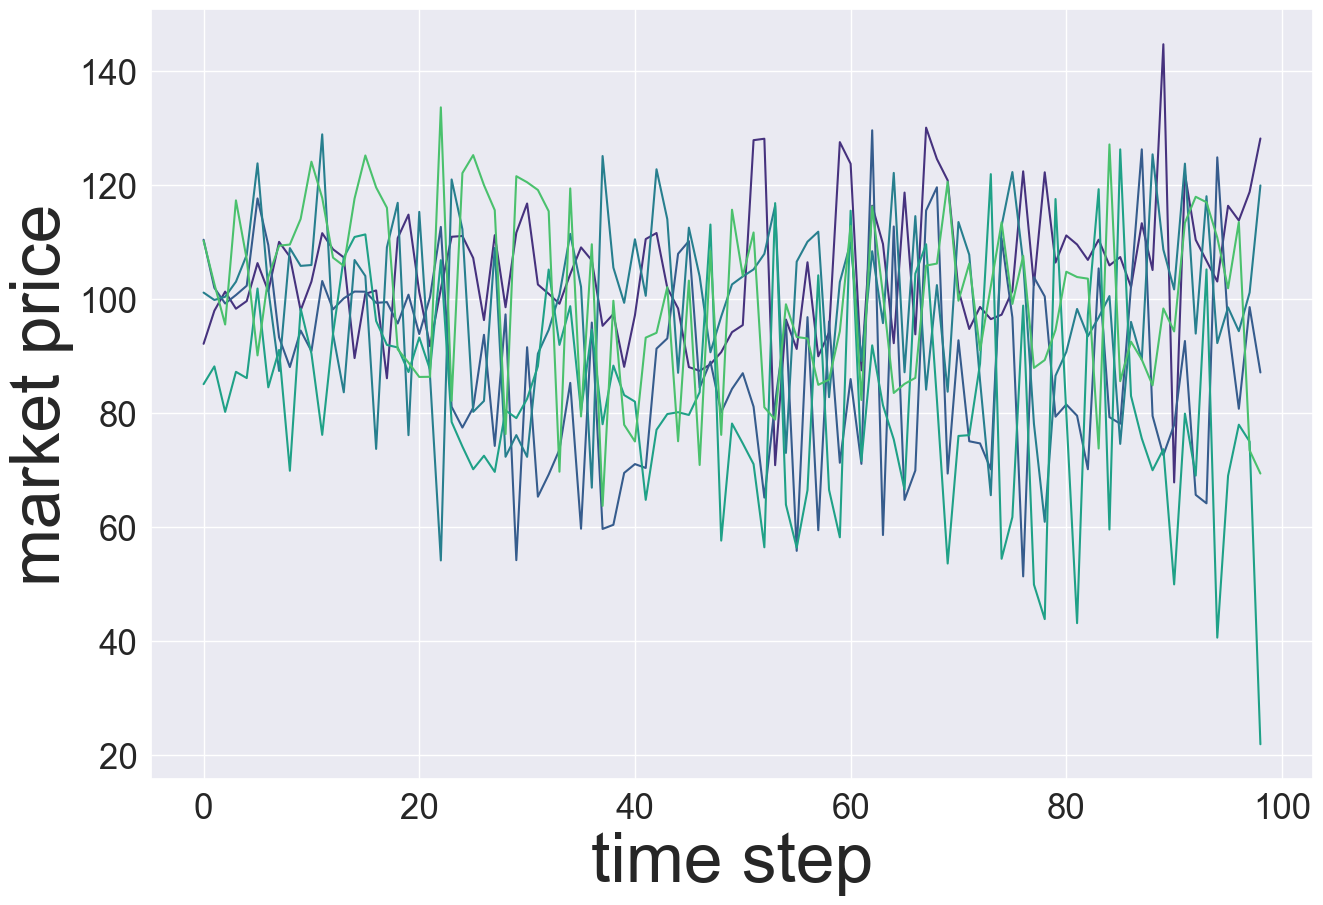

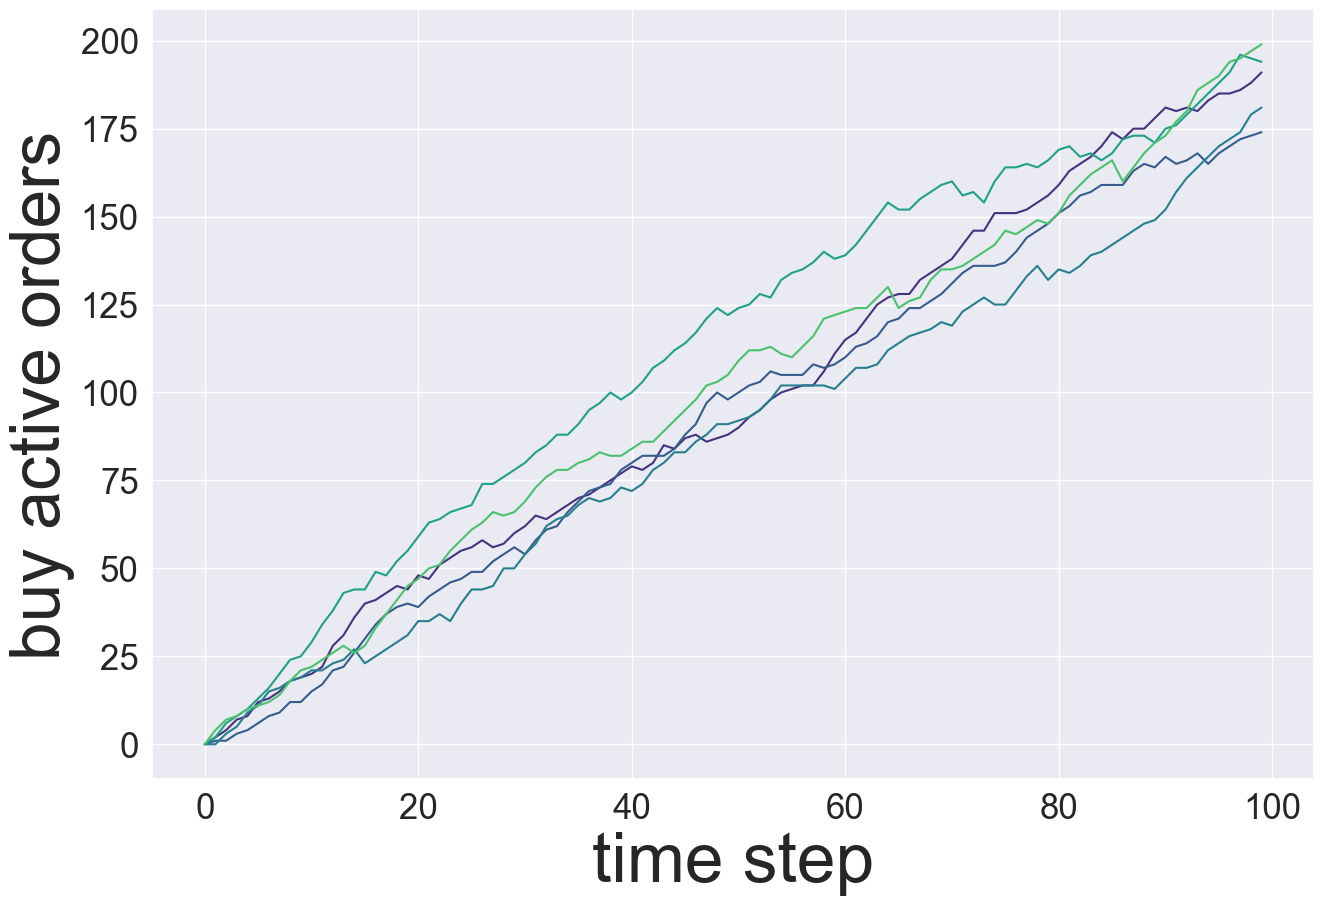

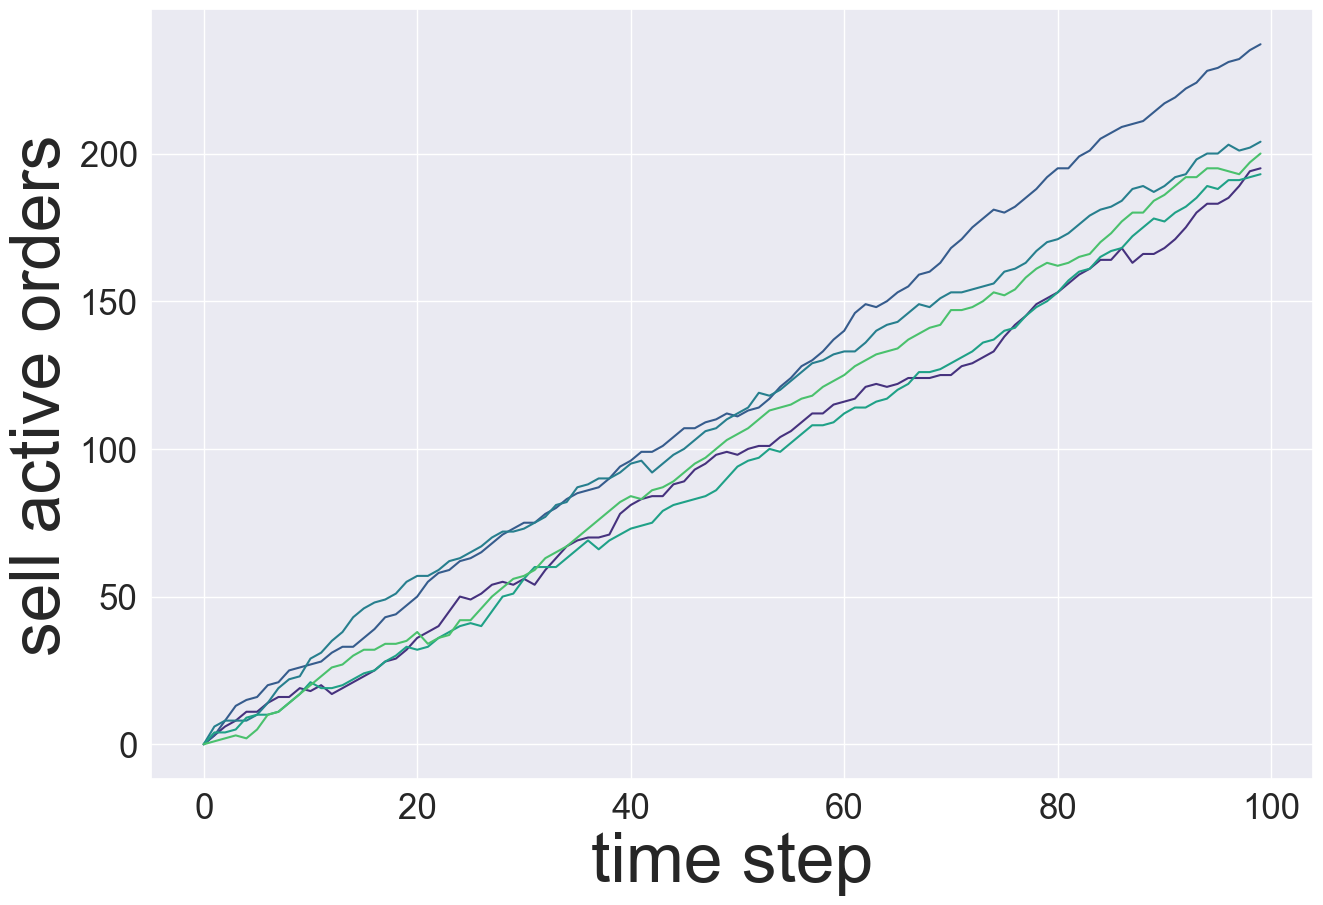

In [21]:
main()